# Efficient Algorithms for Lasso Regression

The main code for this notebook can be found in the [courselib](./courselib/__init__.py) package.

In [1]:
%load_ext autoreload
%autoreload 2

import courselib
import courselib.data  # pyright: ignore[reportUnusedImport]
import courselib.optimizer  # pyright: ignore[reportUnusedImport]
import courselib.utils  # pyright: ignore[reportUnusedImport]
import courselib.models.compressive  # pyright: ignore[reportUnusedImport]

We begin by importing some required modules.

In [2]:
import os
import inspect
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

## Compressive sensing
The key ideas behind Lasso are best understood from the perspective of *compressive sensing*. Given a matrix $\mathbf{X} \in \R^{m \times N}$ with $N \gg m$ and data $\mathbf{y} \in \R^N$, our goal is to recover $\mathbf{w} \in \R^N$ satisfying
$$
    \mathbf{X} \mathbf{w} = \mathbf{y}
$$
In general, this system of equations is under determined an there are infinitely many solutions. We restrict ourselves to only finding solutions that are _sparse_.

The problem can equivalently be understood as a _linear regression_ problem, where $\mathbf{X}$ and $\mathbf{y}$ form a dataset and $\mathbf{w}$ is part of a linear regression model.

Ideally one wants to solve a minimization problem of the form
$$
    \argmin_{\mathbf{w} \in \R} \| \mathbf{w} \|_0 \quad \text{subject to} \quad \mathbf{X} \mathbf{w} = \mathbf{y}
$$
where $\| \cdot \|_0$ is a measure of sparsity, most commonly the number of zero entries. In general, solving this problem is NP-hard. In the regression case, of often is not necessarily interested in exact solutions.

This leads to the Lasso regression problem, which is commonly defined as

$$ \argmin_{\mathbf{w} \in \mathbb{R}^d} \frac{1}{2n} \|\mathbf{Xw} - \mathbf{y}\|_2^2 + \lambda \|\mathbf{w}\|_1 $$

The first term solves the linear regression problem while the additional regularization term promotes sparsity. The choice of $\lambda$ here is critical, since it dictates the tradeoff, between exact solutions to the linear regression problem and the sparsity of $\mathbf{w}$.

In the lecture, we already discussed the non-smoothness due to the $\|\mathbf{w}\|_1$ term, which is non-differentiable. We cannot apply gradient descent directly. Instead, the naive approach involves *subgradient descent*

$$ \mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \frac{\eta}{n} \left( \mathbf{X}^T ( \mathbf{X} \mathbf{w}^{(t)} - \mathbf{y}) + \lambda \cdot \text{sign}(\mathbf{w}^{(t)}) \right) $$

This is implemented in the `courselib.SubGradientDescent` class.

In [3]:
print(inspect.getsource(courselib.optimizer.SubGradientDescent.step))

    @override
    def step(
        self,
        model: CompressiveLinearModel,
        params: dict[str, np.typing.NDArray[np.float64]],
    ):
        X = params["X"]
        y = params["y"]
        residual = model(X) - y
        grad = X.T @ residual / X.shape[0] + self.lam * np.sign(model.w)
        model.w -= self.learning_rate * grad



We compare this to Proximal Gradient Descent (ISTA) whose updated are defined as

$$ \mathbf{w}^{(t+1)} = \text{prox}_{\eta \lambda} \left( \mathbf{w}^{(t)} - \eta \nabla g(\mathbf{w}^{(t)}) \right) $$

with $g(x) = \frac{1}{2n} \| \mathbf{X} \mathbf{w} - \mathbf{y} \|_2^2$ and the proximal operator defined as

$$ \text{prox}_{\eta \lambda}(z_j) = \text{sign}(z_j) \cdot \max\left( |z_j| - \eta \lambda, \, 0 \right) $$

The advantage lies in the proximal operator, which pushes small values towards zero and promotes sparsity.

The corresponding code is in the `courselib.optimizer.ISTA` class.

In [4]:
print(inspect.getsource(courselib.optimizer.ISTA.step))

    @override
    def step(
        self,
        model: CompressiveLinearModel,
        params: dict[str, np.typing.NDArray[np.float64]],
    ):
        X = params["X"]
        y = params["y"]
        grad = X.T @ (X @ model.w - y)

        model.w = prox(
            model.w - self.learning_rate * grad, self.learning_rate * self.lam
        )



## Convergence and Sparsity

Our first goal is to compare the convergence rates of Subgradient Descent and ISTA and compare the sparsity of the resulting solution.

As a synthetic dataset, we consider
$$ \mathbf{y} = \mathbf{X} \mathbf{w}^* + \mathbf{\epsilon} $$
where $\textbf{X}$ is a matrix with gaussian entries and $\mathbf{w}$ is chosen such that $\| \mathbf{w} \|_0 \ll d$ and $\epsilon$ in normally distributed noise. In this case, we focus on the linear regression interpretation of Lasso, since the $\mathbf{\epsilon}$ means that the linear equation cannot be solved directly.

To ensure reproducibility, we use a seedable RNG

In [5]:
generator = np.random.default_rng(0xDEADBEEF)

We generate a dataset with 100 items of dimension 60, with underlying sparsity of 10 (meaning 50 non zero entries).

In [6]:
(X, y, _) = courselib.data.generate_dataset(60, 100, 10, noise_scale=0.1, generator=generator)

There is no universally accepted measure of sparsity. We take

$$ \| w \|_0 = \# \{ j, w_j \leq\epsilon \} $$

which allows for vectors to only be approximately sparse, i.e. it allows for some noise in the measurement of $w$ to be accepted as sparse. The tradeoff is that this requires $\epsilon$ to be chosen appropriately. 

In [7]:
print(inspect.getsource(courselib.utils.sparsity))

def sparsity(vector: np.typing.NDArray[np.float64], epsilon: float = 0.0001) -> float:
    """
    Computes the approximate sparsity of a vector

    Parameters
    ----------
    vector :
        The vector to consider
    epsilon : float, optional
        The constant below which entries are classified as sparse
    """
    return float(np.less(vector, epsilon).sum())



We begin by comparing subgradient descent and ISTA with $w_0$ being chosen randomly.

In [8]:
w_0 = generator.normal(size=[60])
sub_optim = courselib.optimizer.SubGradientDescent(learning_rate=0.0001, lam=0.5)
ista = courselib.optimizer.ISTA(learning_rate=0.0001, lam=0.5)
model_1 = courselib.models.compressive.CompressiveLinearModel(w_0)
model_2 = deepcopy(model_1)

In [9]:
def l2(x_1: np.typing.NDArray[np.float64], x_2: np.typing.NDArray[np.float64]):
    return float(np.linalg.norm(x_2 - x_1))

In [10]:
convergence_metrics_1 = courselib.fit(model_1, sub_optim, X, y, num_epochs=10000, metrics_dict={"l2": l2})
convergence_metrics_2 = courselib.fit(model_2, ista, X, y, num_epochs=10000, metrics_dict={"l2": l2})

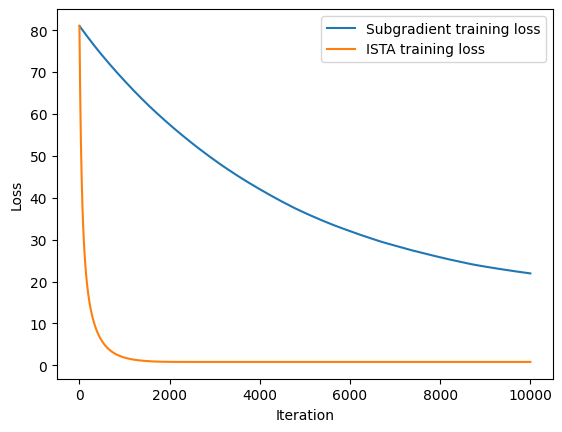

In [11]:
plt.plot(convergence_metrics_1["l2"])
plt.plot(convergence_metrics_2["l2"])
plt.legend(
    [
        "Subgradient training loss",
        "ISTA training loss",
    ]
)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

This indicated that ISTA results on a much better convergence rate.

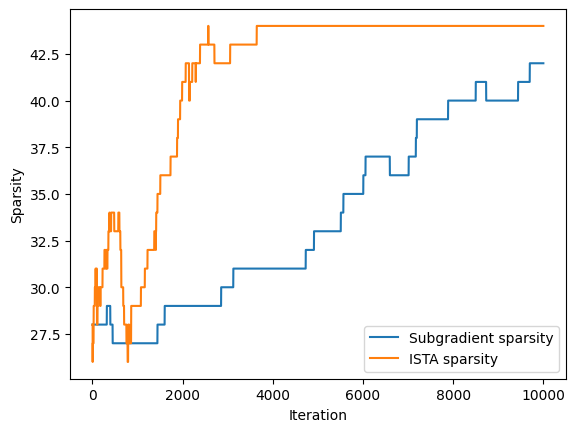

In [12]:
plt.plot(convergence_metrics_1["sparsity"])
plt.plot(convergence_metrics_2["sparsity"])
plt.legend(
    [
        "Subgradient sparsity",
        "ISTA sparsity",
    ]
)
plt.xlabel("Iteration")
plt.ylabel("Sparsity")
plt.show()

Similarly, the ISTA iterates approach higher sparsity in fewer iterations.

In [13]:
print("Subgradient sparsity: ", convergence_metrics_1["sparsity"][-1])
print("ISTA sparsity:", convergence_metrics_2["sparsity"][-1])

Subgradient sparsity:  42.0
ISTA sparsity: 44.0


We can see that the ISTA iterates get closer to the optimal sparsity of 50.

## Path behavior

We additionally seek to study the path the parameters take during training. Here, we also compare different initialization strategies for $w_0$.

We begin by visualizing the path behavior in 2 dimensions. We generate the dataset in the same way as above, but only a dimension of 2 and no noise added to $\mathbf{w}$.

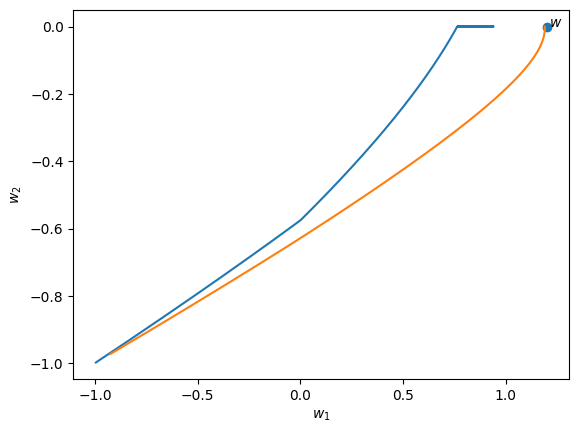

In [14]:
(X_2d, y_2d, w) = courselib.data.generate_dataset(
    2, 20, 1, noise_scale=0.0, w=np.array([1.2, 0.0])
)

w_0 = np.array([-1.0, -1.0])
sub_optim = courselib.optimizer.SubGradientDescent(learning_rate=0.001, lam=0.3)
ista = courselib.optimizer.ISTA(learning_rate=0.001, lam=0.3)
model_1 = courselib.models.compressive.CompressiveLinearModel(w_0)
model_2 = deepcopy(model_1)

metrics_normal_1 = courselib.fit(
    model_1, sub_optim, X_2d, y_2d, num_epochs=2000, metrics_dict={"l2": l2}
)
metrics_normal_2 = courselib.fit(
    model_2, ista, X_2d, y_2d, num_epochs=2000, metrics_dict={"l2": l2}
)

plt.plot(
    np.array(metrics_normal_1["path"])[:, 0], np.array(metrics_normal_1["path"])[:, 1]
)
plt.plot(
    np.array(metrics_normal_2["path"])[:, 0], np.array(metrics_normal_2["path"])[:, 1]
)

plt.xlabel("$w_1$")
plt.ylabel("$w_2$")

plt.scatter(w[0], w[1])
plt.text(w[0] + 0.01, w[1], "$w$")

plt.show()

This example demonstrates the dependence of subgradient descent on the choice of $\lambda$ very well. Initially, both approaches follow a similar gradient. Choosing large parameters for $\lambda$ however, leads to the subgradient method drifting away from the ground truth to prefer sparsity. Note that both methods show some discontinuity whey crossing the coordinate axes.

We also compare $w_0$ with normally distributed entries with zero initialization on the original dataset.

In [15]:
w_0 = generator.normal(size=[60])
sub_optim = courselib.optimizer.SubGradientDescent(learning_rate=0.0001, lam=0.5)
ista = courselib.optimizer.ISTA(learning_rate=0.0001, lam=0.5)
model_1 = courselib.models.compressive.CompressiveLinearModel(w_0)
model_2 = deepcopy(model_1)

metrics_normal_1 = courselib.fit(model_1, sub_optim, X, y, num_epochs=10000, metrics_dict={"l2": l2})
metrics_normal_2 = courselib.fit(model_2, ista, X, y, num_epochs=10000, metrics_dict={"l2": l2})

w_0 = np.zeros([60])
sub_optim = courselib.optimizer.SubGradientDescent(learning_rate=0.0001, lam=0.5)
ista = courselib.optimizer.ISTA(learning_rate=0.0001, lam=0.5)
model_1 = courselib.models.compressive.CompressiveLinearModel(w_0)
model_2 = deepcopy(model_1)

metrics_zero_1 = courselib.fit(model_1, sub_optim, X, y, num_epochs=10000, metrics_dict={"l2": l2})
metrics_zero_2 = courselib.fit(model_2, ista, X, y, num_epochs=10000, metrics_dict={"l2": l2})

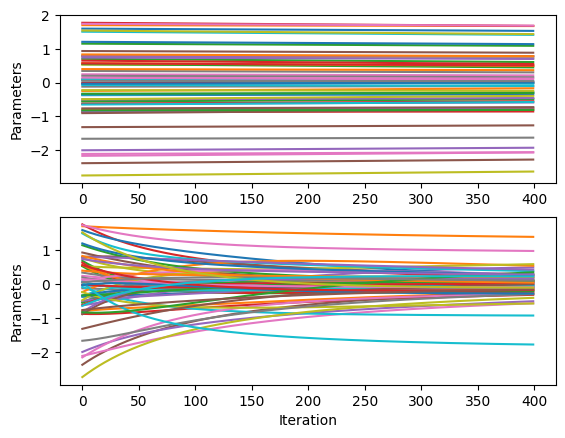

In [16]:
fig, axs = plt.subplots(2)
axs[0].plot(metrics_normal_1["path"][0:400])
axs[0].set_ylabel("Parameters")
axs[1].plot(metrics_normal_2["path"][0:400], label="TEst")
axs[1].set_ylabel("Parameters")

plt.xlabel("Iteration")

plt.show()

In the case of subgradient descent, the parameters uniformly converge to a solution. With ISTA however, the parameters move more quickly during the beginning of training, with most tending to values close to 0.

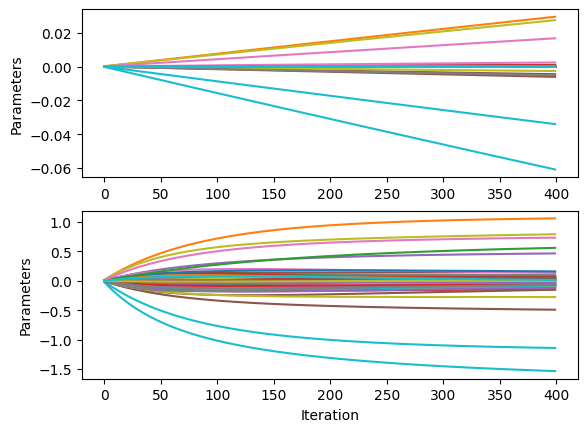

In [17]:
fig, axs = plt.subplots(2)
axs[0].plot(metrics_zero_1["path"][0:400])
axs[0].set_ylabel("Parameters")
axs[1].plot(metrics_zero_2["path"][0:400])
axs[1].set_ylabel("Parameters")

plt.xlabel("Iteration")

plt.show()

With 0 initialization, the subgradient iterated are initially sparse, which helps with sparsity in the final solution. We later do a more rigorous analysis of the evolution of sparsity during training.

## Comparison of different $\lambda$

The LASSO problem contains the hyperparameter $\lambda$ which dictates the tradeoff between exact solutions to the linear regression problem and the sparsity of the desired solution.

In [18]:
lambda_max = np.max(X.T @ y)

In [19]:
sub_sparsity = []
ista_sparsity = []

axes = np.linspace(0.0, lambda_max, 300)

for lam in tqdm(axes):
    sub_optim = courselib.optimizer.SubGradientDescent(learning_rate=0.0001, lam=lam)
    ista = courselib.optimizer.ISTA(learning_rate=0.0001, lam=lam)
    model_1 = courselib.models.compressive.CompressiveLinearModel(generator.normal(size=[60]))
    model_2 = deepcopy(model_1)
    metrics_1 = courselib.fit(model_1, sub_optim, X, y, num_epochs=1000, metrics_dict={"l2": l2})
    metrics_2 = courselib.fit(model_2, ista, X, y, num_epochs=1000, metrics_dict={"l2": l2})

    sub_sparsity.append(metrics_1["sparsity"][-1])
    ista_sparsity.append(metrics_2["sparsity"][-1])

  0%|          | 0/300 [00:00<?, ?it/s]

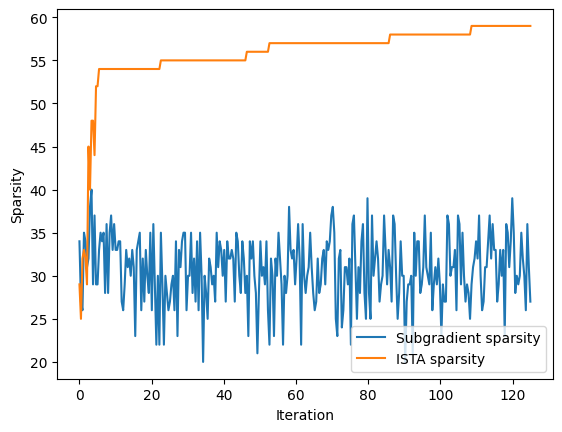

In [20]:
plt.plot(axes, sub_sparsity)
plt.plot(axes, ista_sparsity)
plt.legend(
    [
        "Subgradient sparsity",
        "ISTA sparsity",
    ]
)
plt.xlabel("Iteration")
plt.ylabel("Sparsity")
plt.show()

With ISTA, higher parameters of $\lambda$ directly lead to higher sparsity in the final solution. With subgradient descent, there is so such clear trend.

## Sensitivity to initialization

We further analyze the resulting sparsity of the solution based on initialization. In particular, we compare
- Zero initialization
- Normal initialization
- Initialization by the normal equation solution for linear least squares regression

In [21]:
w_0 = np.zeros([60])
sub_optim = courselib.optimizer.SubGradientDescent(learning_rate=0.001)
ista = courselib.optimizer.ISTA(learning_rate=0.001)
model_1 = courselib.models.compressive.CompressiveLinearModel(w_0)
model_2 = deepcopy(model_1)
metrics_zeros_1 = courselib.fit(model_1, sub_optim, X, y, num_epochs=1000, metrics_dict={"l2": l2})
metrics_zeros_2 = courselib.fit(model_2, ista, X, y, num_epochs=1000, metrics_dict={"l2": l2})

w_0 = generator.normal(size=[60])
sub_optim = courselib.optimizer.SubGradientDescent(learning_rate=0.001)
ista = courselib.optimizer.ISTA(learning_rate=0.001)
model_1 = courselib.models.compressive.CompressiveLinearModel(w_0)
model_2 = deepcopy(model_1)
metrics_normal_1 = courselib.fit(model_1, sub_optim, X, y, num_epochs=1000, metrics_dict={"l2": l2})
metrics_normal_2 = courselib.fit(model_2, ista, X, y, num_epochs=1000, metrics_dict={"l2": l2})

w_0 = np.linalg.inv(X.T @ X) @ (X.T @ y)
sub_optim = courselib.optimizer.SubGradientDescent(learning_rate=0.001)
ista = courselib.optimizer.ISTA(learning_rate=0.001)
model_1 = courselib.models.compressive.CompressiveLinearModel(np.random.normal(size=[60]))
model_2 = deepcopy(model_1)
metrics_least_1 = courselib.fit(model_1, sub_optim, X, y, num_epochs=1000, metrics_dict={"l2": l2})
metrics_least_2 = courselib.fit(model_2, ista, X, y, num_epochs=1000, metrics_dict={"l2": l2})

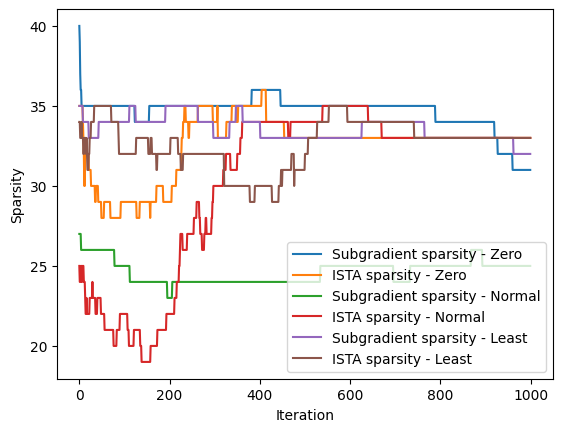

In [22]:
plt.plot(metrics_zeros_1["sparsity"])
plt.plot(metrics_zeros_2["sparsity"])
plt.plot(metrics_normal_1["sparsity"])
plt.plot(metrics_normal_2["sparsity"])
plt.plot(metrics_least_1["sparsity"])
plt.plot(metrics_least_2["sparsity"])
plt.legend(
    [
        "Subgradient sparsity - Zero",
        "ISTA sparsity - Zero",
        "Subgradient sparsity - Normal",
        "ISTA sparsity - Normal",
        "Subgradient sparsity - Least",
        "ISTA sparsity - Least",
    ]
)
plt.xlabel("Iteration")
plt.ylabel("Sparsity")
plt.show()

While only a single trajectory can only convey very little, zero and least squares initialization seem to outperform normal initialization.

## Convergence with learning rate

In our analysis so far, we have chosen the same `learning_rate` for subgradient descent and ISTA. A priori, it is possible that the convergence of subgradient descent highly depends on the `learning_rate` and that more optimal learning rates could outperform ISTA. We therefore compare both algorithms over a range of learning rates.

In [23]:
sub_error = []
ista_error = []

axes = np.linspace(0.0001, 0.006, 300)

for learning_rate in tqdm(axes):
    sub_optim = courselib.optimizer.SubGradientDescent(learning_rate=learning_rate)
    ista = courselib.optimizer.ISTA(learning_rate=learning_rate)
    model_1 = courselib.models.compressive.CompressiveLinearModel(np.random.normal(size=[60]))
    model_2 = deepcopy(model_1)
    metrics_1 = courselib.fit(model_1, sub_optim, X, y, num_epochs=1000, metrics_dict={"l2": l2})
    metrics_2 = courselib.fit(model_2, ista, X, y, num_epochs=1000, metrics_dict={"l2": l2})

    sub_error.append(metrics_1["l2"][-1])
    ista_error.append(metrics_2["l2"][-1])

  0%|          | 0/300 [00:00<?, ?it/s]

The interval $[0.0001, 0.006]$ was chosen based on stability, since higher learning rates result in numerical instability.

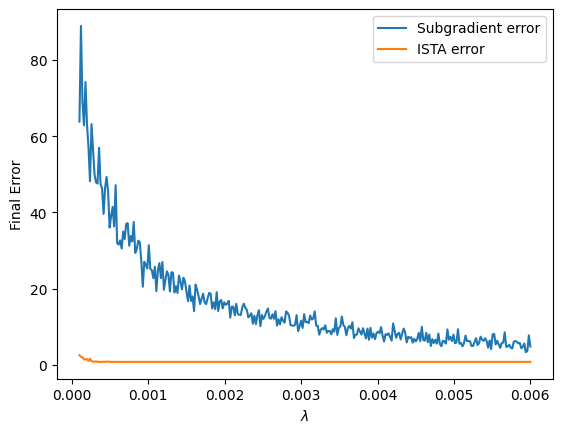

In [24]:
plt.plot(axes, sub_error)
plt.plot(axes, ista_error)
plt.legend(
    [
        "Subgradient error",
        "ISTA error",
    ]
)
plt.xlabel("$\\lambda$")
plt.ylabel("Final Error")
plt.show()

While the convergence of subgradient descent depends on the learning rate, it does not outperform ISTA until becoming numerically unstable.

## Boston Housing

So far, we have only used synthetic datasets for our evaluation. To validate our experiments, we additionally compare convergence rate on the Boston Housing dataset.

In [25]:
file_name = 'boston_housing.csv'
url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'

if os.path.exists(file_name):
    print(f'Loading data from local file `{file_name}`...')
    df = pd.read_csv(file_name, index_col=0)
else:
    print(f'Loading data from `{url}`...')
    df = pd.read_csv(url)
    df.to_csv(file_name)
    print('Done.')

Loading data from local file `boston_housing.csv`...


In [26]:
df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [27]:
def normalize(x):
    return (x - np.mean(x, axis=0))/np.std(x,axis=0)

In [28]:
X = normalize(df.iloc[:,df.columns != 'medv'].to_numpy())
y = df.iloc[:,df.columns == 'medv'].to_numpy().reshape(-1)

In [29]:
lam = 0.0001

sub_optim = courselib.optimizer.SubGradientDescent(learning_rate=0.00001, lam=lam)
ista = courselib.optimizer.ISTA(learning_rate=0.00001, lam=lam)
model_1 = courselib.models.compressive.CompressiveLinearModel(generator.normal(size=[X.shape[1]]))
model_2 = deepcopy(model_1)

metrics_1 = courselib.fit(model_1, sub_optim, X, y, num_epochs=100, metrics_dict={"l2": l2})
metrics_2 = courselib.fit(model_2, ista, X, y, num_epochs=100, metrics_dict={"l2": l2})

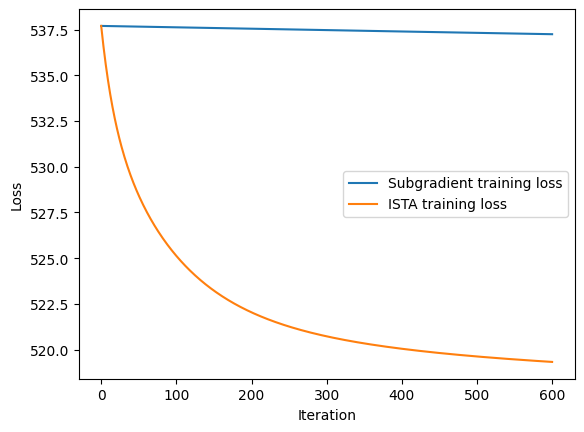

In [30]:
plt.plot(metrics_1["l2"])
plt.plot(metrics_2["l2"])
# plt.yscale("log")
# plt.xscale("log")
plt.legend(
    [
        "Subgradient training loss",
        "ISTA training loss",
    ]
)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

The lower bound of $\approx 520$ due to the Boston housing data being _affine_ instead of _linear_. Here, we again see ISTA outperform subgradient descent in terms of convergence.

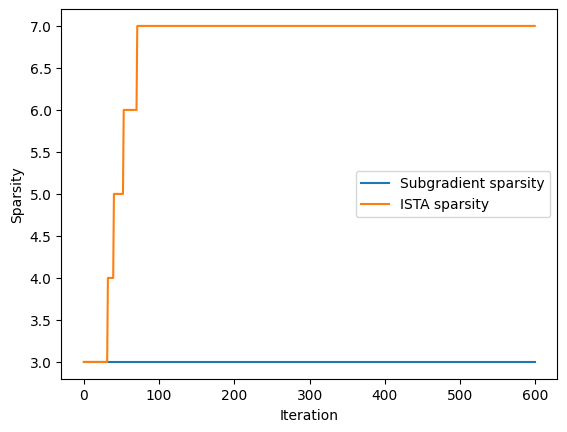

In [31]:
plt.plot(metrics_1["sparsity"])
plt.plot(metrics_2["sparsity"])
# plt.yscale("log")
# plt.xscale("log")
plt.legend(
    [
        "Subgradient sparsity",
        "ISTA sparsity",
    ]
)
plt.xlabel("Iteration")
plt.ylabel("Sparsity")
plt.show()

ISTA achieves better levels of sparsity despite the relative low dimension of the input data.

## Elastic Net

Lasso achieves sparse solutions by using an $l_1$ regularization term. Elastic net by contrast, uses $l_1$ and $l_2$ regularization, i.e.

$$ \min_{\mathbf{w} \in \mathbb{R}^d} \frac{1}{2n} \|\mathbf{Xw} - \mathbf{y}\|_2^2 + \lambda_1 \|\mathbf{w}\|_1 + \lambda_2 \|\mathbf{w}\|_2 $$

We then approximate a minimizer via subgradient descent.

In [32]:
(X, y, _) = courselib.data.generate_dataset(60, 100, 10, noise_scale=0.1, generator=generator)

w_0 = generator.normal(size=[60])
sub_optim = courselib.optimizer.SubGradientDescent(learning_rate=0.0001, lam=0.5)
ista = courselib.optimizer.ISTA(learning_rate=0.0001, lam=0.5)
elastic = courselib.optimizer.ElasticNet(learning_rate=0.0001, lam_1=0.5, lam_2=0.5)
model_1 = courselib.models.compressive.CompressiveLinearModel(w_0)
model_2 = deepcopy(model_1)
model_3 = deepcopy(model_1)

metrics_1 = courselib.fit(model_1, sub_optim, X, y, num_epochs=10000, metrics_dict={"l2": l2})
metrics_2 = courselib.fit(model_2, ista, X, y, num_epochs=10000, metrics_dict={"l2": l2})
metrics_3 = courselib.fit(model_3, elastic, X, y, num_epochs=10000, metrics_dict={"l2": l2})

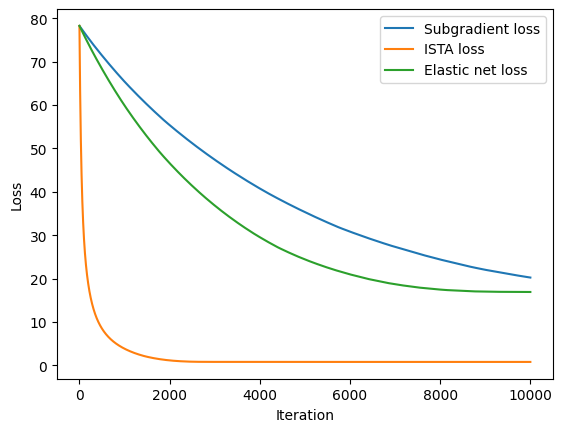

In [33]:
plt.plot(metrics_1["l2"])
plt.plot(metrics_2["l2"])
plt.plot(metrics_3["l2"])
plt.legend(
    [
        "Subgradient loss",
        "ISTA loss",
        "Elastic net loss",
    ]
)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

Since the regular Lasso solver and Elastic net both use subgradient descent, they achieve comparable convergence rates.

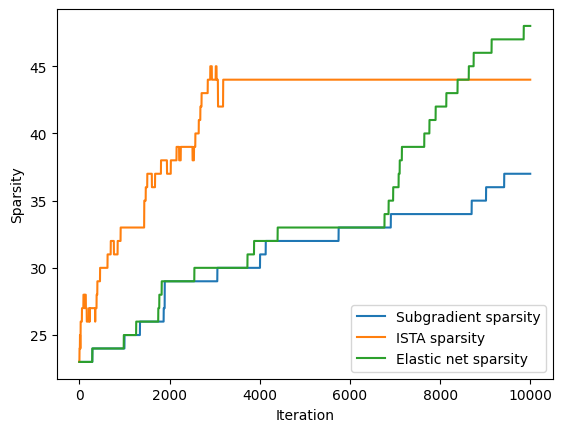

In [34]:
plt.plot(metrics_1["sparsity"])
plt.plot(metrics_2["sparsity"])
plt.plot(metrics_3["sparsity"])
plt.legend(
    [
        "Subgradient sparsity",
        "ISTA sparsity",
        "Elastic net sparsity",
    ]
)
plt.xlabel("Iteration")
plt.ylabel("Sparsity")
plt.show()

While ISTA finds a sparse solution more quickly, elastic net leads to higher final sparsity in this case. This result is of course highly dependent on the choice of $\lambda$, $\lambda_1$ and $\lambda_2$.

## Conclusion

We have have found many instances in which ISTA outperforms subgradient descent in both convergence rate and sparseness. This translates to better performance, despite the more complex update steps involved in ISTA. The main advantage of subgradient descent lies in its simplicity. Many frameworks support subgradient descent out of the box and gradient based update steps fit into common optimization workflows. Similar tradeoff hold between ISTA and elastic net.